In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [86]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer'
                    ]
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']

def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='0':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
def substrings_in_string(big_string, substrings, default=np.nan):
    if pd.isnull(big_string):
        return default
    for substring in substrings:
        if substring in big_string:
            return substring
    return default

# pre processing
def preprocess(df, is_Train = True):
    df = df.copy()
    df['Sex'] = df['Sex'].map({'male': -1, 'female': 1})

    # Title 추출 및 그룹화
    df['Title'] = df['Name'].map(lambda x: substrings_in_string(x, title_list))
    df['Title'] = df.apply(replace_titles, axis=1)

    # Age 평균으로 결측치 채우기
    df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('mean'))
    
    # Embarked 처리
    df['Embarked'] = df['Embarked'].fillna('Unknown')
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2 , 'Unknown' : -1})

    # Family size 생성
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Fare 결측치 처리
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('mean'))
    
    # Fare / FamilySize 
    df['F/F'] = df['Fare'] /  df['FamilySize'] 
    
    df['FareGroup'] = pd.qcut(df['Fare'], q=4, labels=[1, 2, 3,4])
    df['FareGroup'] = df['FareGroup'].astype(int)
    
    df['FareGroup_Sex'] = df['FareGroup'] * df['Sex']
    
    # Deck 추출
    df['Deck'] = df['Cabin'].apply(lambda x: substrings_in_string(x, cabin_list, default='Unknown'))
    df['Deck'] = df['Deck'].map(dict(zip(cabin_list, range(len(cabin_list)))))
    
    x = df.drop(columns=[
        'Title', 'Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp' , 'Parch',
        'FareGroup','Embarked'
        ])
    print(x.columns,'\n')
    
    # 불필요한 열 제거 (PassengerId는 따로 저장해둘 것)
    if is_Train:
        y = df['Survived']
        x = x.drop(columns=['Survived'])
        return x, y
    
    return x

In [87]:
processed_df,labels = preprocess(df)
processed_df.info()

X = processed_df
y = labels

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'F/F',
       'FareGroup_Sex', 'Deck'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         891 non-null    int64  
 1   Sex            891 non-null    int64  
 2   Age            891 non-null    float64
 3   Fare           891 non-null    float64
 4   FamilySize     891 non-null    int64  
 5   F/F            891 non-null    float64
 6   FareGroup_Sex  891 non-null    int64  
 7   Deck           891 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1602)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
# XgBoost 
xgb_model = XGBClassifier(random_state=2934)
xgb_model.fit(X_train,y_train)

# 모델 성능 예측

y_pred = model.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("XGB Accuracy:", accuracy_score(y_test, xgb_y_pred))
print(classification_report(y_test, xgb_y_pred))

Accuracy: 0.8295964125560538
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       136
           1       0.80      0.75      0.77        87

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223

XGB Accuracy: 0.8116591928251121
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       136
           1       0.78      0.72      0.75        87

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



In [89]:
params = {
    'n_estimators': [100, 200, 250, 500],
    'max_depth': [10, 15,20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    "criterion" : ['gini', 'entropy', 'log_loss'],
    'class_weight' : ['balanced', 'balanced_subsample']
}

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# GridSearchCV 적용
grid_search = RandomizedSearchCV(
    n_iter= 10,
    estimator=model,
    param_distributions=params,
    cv=rskf,
)

# 학습
grid_search.fit(X_train, y_train)

# 최적 파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_estimators': 250, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'log_loss', 'class_weight': 'balanced'}


In [91]:
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

probs = best_rf_model.predict_proba(X_test)
p1 = probs[:,1]
p0 = probs[:,0]
prob_diff = np.abs(p1-p0)
uncertain_indices = np.where(prob_diff <= 0.08)[0]

# 애매한 샘플 확인
X_uncertain = X_test.iloc[uncertain_indices]
uncertain_probs = probs[uncertain_indices]


print("Test Accuracy:", accuracy_score(y_test, y_pred))

# 출력 예시
print(f"애매한 샘플 수: {len(X_uncertain)}")
print(uncertain_probs)

Test Accuracy: 0.8071748878923767
애매한 샘플 수: 11
[[0.47539492 0.52460508]
 [0.47603858 0.52396142]
 [0.50246148 0.49753852]
 [0.46734234 0.53265766]
 [0.5079171  0.4920829 ]
 [0.47410878 0.52589122]
 [0.52169927 0.47830073]
 [0.4692116  0.5307884 ]
 [0.52144106 0.47855894]
 [0.49305278 0.50694722]
 [0.46874905 0.53125095]]


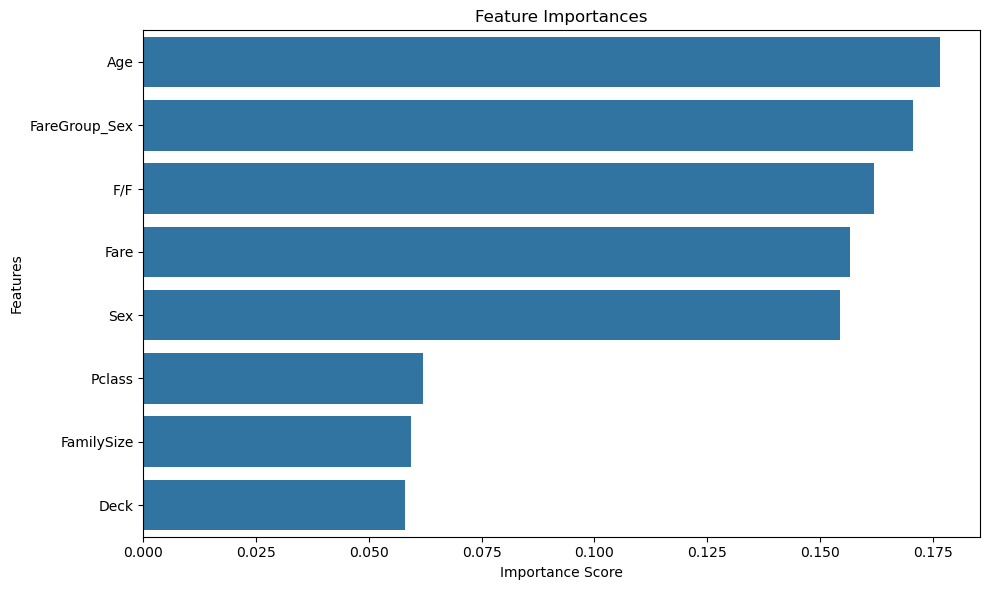

In [92]:
def plot_feature_importances(model, feature_names, top_n=20):
    """
    트리 기반 모델의 피처 중요도를 시각화합니다.
    
    Parameters:
    - model: 학습된 모델 (feature_importances_ 속성을 가져야 함)
    - feature_names: 피처 이름 리스트 또는 Series
    - top_n: 상위 n개 피처만 시각화 (기본값: 20개)
    """
    if not hasattr(model, "feature_importances_"):
        raise ValueError("이 모델은 feature_importances_ 속성을 지원하지 않습니다.")

    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    feat_imp_sorted = feat_imp.sort_values(ascending=False)[:top_n]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp_sorted.values, y=feat_imp_sorted.index)
    plt.title("Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    

plot_feature_importances(best_rf_model, feature_names=X_train.columns)

## XGBoost 튜닝 , BayesSearch

In [93]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [94]:
search_spaces = {
    'max_depth': Integer(3, 10),  # 3 ~ 10 사이의 정수
    'n_estimators': Integer(100, 1000), # 100 ~ 500 사이의 정수
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'), # 0.01 ~ 0.3 사이의 실수 (로그 스케일)
    'subsample': Real(0.7, 1.0), # 0.7 ~ 1.0 사이의 실수
    'colsample_bytree': Real(0.7, 1.0) # 0.7 ~ 1.0 사이의 실수
}

bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_spaces,
    n_iter= 50,
    cv = 5,
    scoring='accuracy',
    verbose=1,
    random_state=20
)

bayes_search.fit(X_train, y_train)

# 5. 최적의 결과 확인
print(f"최적의 하이퍼파라미터: {bayes_search.best_params_}")
print(f"최고 교차검증 정확도: {bayes_search.best_score_:.4f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [95]:
best_model_bayes = bayes_search.best_estimator_
preds_bayes = best_model_bayes.predict(X_test)


b_probs = best_model_bayes.predict_proba(X_test)
b_p1 = probs[:,1]
b_p0 = probs[:,0]
b_prob_diff = np.abs(p1-p0)
b_uncertain_indices = np.where(b_prob_diff <= 0.10)[0]

# 애매한 샘플 확인
b_X_uncertain = X_test.iloc[b_uncertain_indices]
b_uncertain_probs = probs[b_uncertain_indices]

# 출력 예시
print(f"애매한 샘플 수: {len(b_X_uncertain)}")
print(b_uncertain_probs)

print("\nAccuracy:", accuracy_score(y_test, preds_bayes))
print(classification_report(y_test, preds_bayes))

애매한 샘플 수: 11
[[0.47539492 0.52460508]
 [0.47603858 0.52396142]
 [0.50246148 0.49753852]
 [0.46734234 0.53265766]
 [0.5079171  0.4920829 ]
 [0.47410878 0.52589122]
 [0.52169927 0.47830073]
 [0.4692116  0.5307884 ]
 [0.52144106 0.47855894]
 [0.49305278 0.50694722]
 [0.46874905 0.53125095]]

Accuracy: 0.820627802690583
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       136
           1       0.79      0.74      0.76        87

    accuracy                           0.82       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.82      0.82       223



In [96]:
#Model 간의 결과값 비교
(y_pred == preds_bayes).mean()

0.9596412556053812

# Stacking 

Base Models: RandomForest + XGBoost

↓ 예측값을 feature로 사용

Meta Model: LogisticRegression

→ 최종 생존 여부 예측

In [97]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [98]:
# 훈련-검증 분리
X_train, X_val, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_test.mean())

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

meta_model = LogisticRegression()

stacking_clf = StackingClassifier(
    estimators = [('rf',best_rf_model), ('xgb',best_model_bayes)],
    final_estimator= meta_model,
    cv=5,
    passthrough = True
)

stacking_clf.fit(X_train_scaled, y_train)

# 검증용 데이터로 예측
y_pred = stacking_clf.predict(X_val_scaled)

# 정확도 확인
from sklearn.metrics import accuracy_score
print("Validation Accuracy:", accuracy_score(y_test, y_pred))

0.4134078212290503
Validation Accuracy: 0.8212290502793296


# MANY MANY MANY MANY MANY MANY

In [ ]:
from sklearn.pipeline import make_pipeline

base_models = []
n_splits = 5

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for i in range(n_splits):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i)

    # GridSearch는 비스케일 데이터로 튜닝하지만, 최종 모델은 스케일된 데이터로 파이프라인 생성
    params = {
    'n_estimators': [100, 200, 250, 500],
    'max_depth': [10, 15,20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    "criterion" : ['gini', 'entropy', 'log_loss'],
    # 'class_weight' : ['balanced', 'balanced_subsample']
    }

    rf = RandomForestClassifier(random_state=i)
    radom_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=params,
        n_iter=30,  # 실험적, 30~50 사이 추천
        cv=rskf,
        scoring='accuracy',
        random_state=i,
        n_jobs=-1
    )
    
    radom_search.fit(X_train, y_train)

    # 최적 모델 + 파이프라인으로 묶기 (스케일링 포함)
    best_rf = radom_search.best_estimator_
    print(radom_search.best_estimator_)
    rf_pipeline = make_pipeline(StandardScaler(), best_rf)
    base_models.append((f'rf_{i}', rf_pipeline))

meta_model = LogisticRegression(max_iter=1000)

# stacking classifier
rf_stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=False,  # 원본 feature도 들어감 (스케일 안 하면 convergence warning)
    cv=cv,
    n_jobs= -1
)

# 전체 데이터 스케일링 (원본 feature 때문에)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# stacking 학습
rf_stacking_clf.fit(X_scaled, y)

RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='log2',
                       min_samples_split=5, n_estimators=250, random_state=0)
RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=1)
RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_split=5,
                       random_state=2)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=250, random_state=3)
RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_split=5,
                       random_state=4)


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('rf_0',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(criterion='log_loss',
                                                                        max_depth=10,
                                                                        max_features='log2',
                                                                        min_samples_split=5,
                                                                        n_estimators=250,
                                                                        random_state=0))])),
                               ('rf_1',
                                Pipeline(steps=[('standardscale...
                                                 RandomForestClassifier(criterion='entropy',
                                                                        max_depth=10,
                                                                        max_features='log2',
                                                                        n_estimators=250,
                                                                        random_state=3))])),
                               ('rf_4',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(criterion='log_loss',
                                                                        max_depth=10,
                                                                        min_samples_split=5,
                                                                        random_state=4))]))],
                   final_estimator=LogisticRegression(max_iter=1000),
                   n_jobs=-1)

In [100]:
from sklearn.metrics import accuracy_score, classification_report

# 학습할 때 스케일링 했던 것 그대로 사용
X_scaled = scaler.transform(X)
y_pred_train = stacking_clf.predict(X_scaled)

# 정확도 계산
acc = accuracy_score(y, y_pred_train)
print(f"Training Accuracy: {acc:.4f}")

# 자세한 리포트
print(classification_report(y, y_pred_train))

Training Accuracy: 0.8462
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       549
           1       0.91      0.67      0.77       342

    accuracy                           0.85       891
   macro avg       0.86      0.81      0.83       891
weighted avg       0.85      0.85      0.84       891



# Submission

In [77]:
def submission(model,file,to_name='submission.csv'):
    test_data = pd.read_csv(file)
    passenger_ids = test_data['PassengerId']

    processed_test_data = preprocess(test_data, is_Train=False)
    processed_test_data.info()
    
    processed_test_data_scaled = scaler.transform(processed_test_data)
    predictions = model.predict(processed_test_data_scaled)

    submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': predictions.astype(int)
    })
    submission.to_csv(to_name, index=False)

In [101]:
submission(rf_stacking_clf,file='test.csv', to_name = 'rf_stacking_clf.csv')

Index(['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'F/F', 'FareGroup_Sex',
       'Deck'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         418 non-null    int64  
 1   Sex            418 non-null    int64  
 2   Age            418 non-null    float64
 3   Fare           418 non-null    float64
 4   FamilySize     418 non-null    int64  
 5   F/F            418 non-null    float64
 6   FareGroup_Sex  418 non-null    int64  
 7   Deck           418 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 26.3 KB


In [61]:
s2_df = pd.read_csv('submission2.csv')
s2_df.Survived.mean()

0.35167464114832536

In [79]:
sub_df = pd.read_csv('rf_xgb.csv')
sub_df.Survived.mean()

0.3444976076555024

In [102]:
rf_stacking_df = pd.read_csv('rf_stacking_clf.csv')
rf_stacking_df.Survived.mean()

0.3492822966507177